In [1]:
import lightning.pytorch as pl
import pandas as pd
import torch
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAPE, SMAPE, RMSE, MAE, MASE

from thesis.dataloading import load_eld

In [2]:
pl.seed_everything(42)

Seed set to 42


42

In [3]:
data, freq = load_eld("./datasets/LD2011_2014.txt")
data = (
    data.reset_index()
    .reset_index()
    .rename(columns={"index": "time_idx"})
    .set_index(["time_idx", "date"])
    .rename_axis("series", axis="columns")
    .stack()
    .rename("value")  # type: ignore
    .reset_index()
)

In [4]:
horizon = pd.Timedelta(7, "day")

output_length = horizon // freq
input_length = 3 * output_length
training_cutoff = data["time_idx"].max() - output_length

assert pd.DataFrame.equals(
    data[(data["series"] == "MT_001") & (data["time_idx"] <= training_cutoff)],
    data[(data["series"] == "MT_001") & (data["date"] <= data["date"].max() - horizon)],
)

print(f"{input_length = }\n{output_length = }\n{training_cutoff = }")

input_length = 252
output_length = 84
training_cutoff = 2820


In [5]:
# create dataset and dataloaders
training = TimeSeriesDataSet(
    data[data["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=input_length,
    max_prediction_length=output_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)
batch_size = 1024
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=2
)

/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:187: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  y = torch.as_tensor(y)


In [6]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).cuda()
baseline_predictions = Baseline().predict(val_dataloader)
MAPE()(baseline_predictions, actuals).item()

/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For mor

0.25164616107940674

In [7]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback, checkpoint_callback],
    default_root_dir="./output/eld/nbeats/"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    expansion_coefficient_lengths=[3, 1],
    widths=[256, 2048],
    backcast_loss_ratio=0.0,
    loss=SMAPE(),
    
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  coefficients = torch.tensor([backcast_linspace**i for i in range(thetas_dim)], dtype=torch.float32)
Missing logger folder: output/eld/nbeats/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAPE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 27.8 M
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = "./output/eld/nbeats/lightning_logs/version_0/checkpoints/epoch=10-step=1331.ckpt"
best_model = NBeats.load_from_checkpoint(best_model_path)

/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/konstantinos/projects/thesis/code/env/lib/python3.10/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  coeffic

In [14]:
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).cuda()
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


14.587855339050293

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


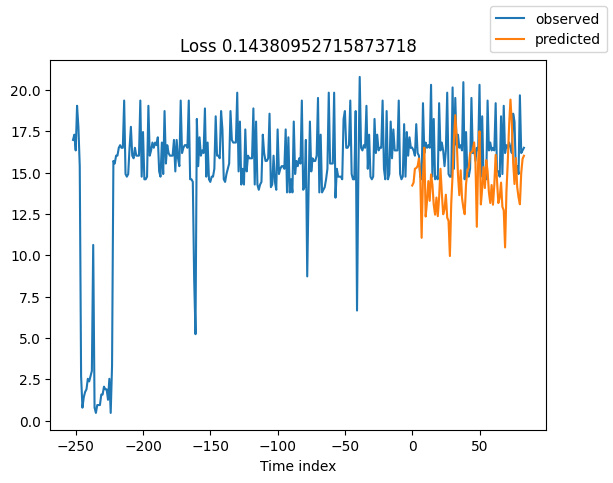

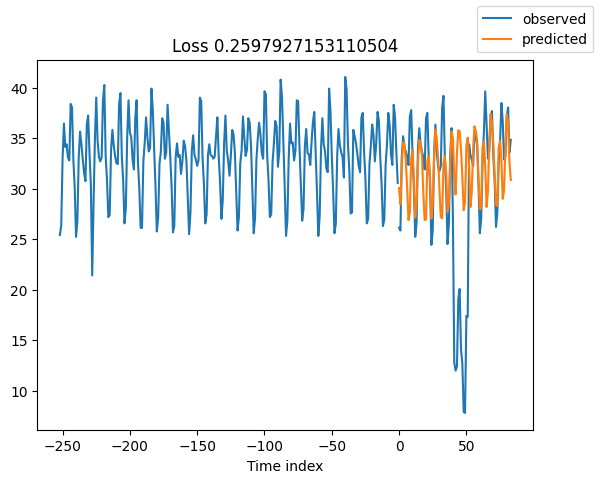

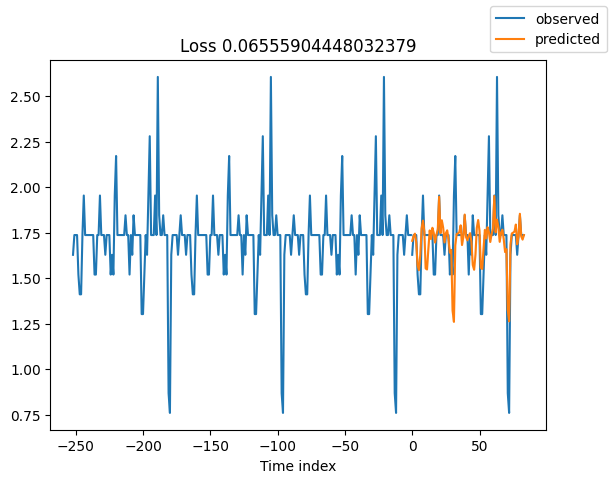

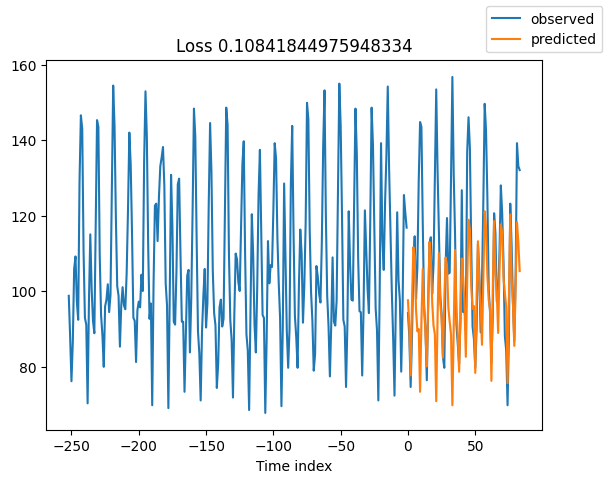

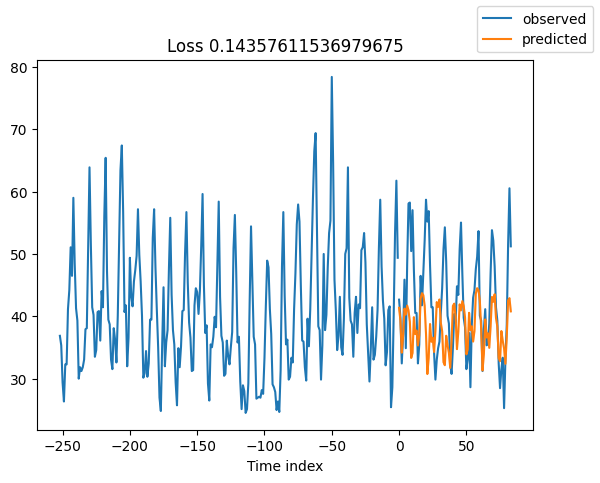

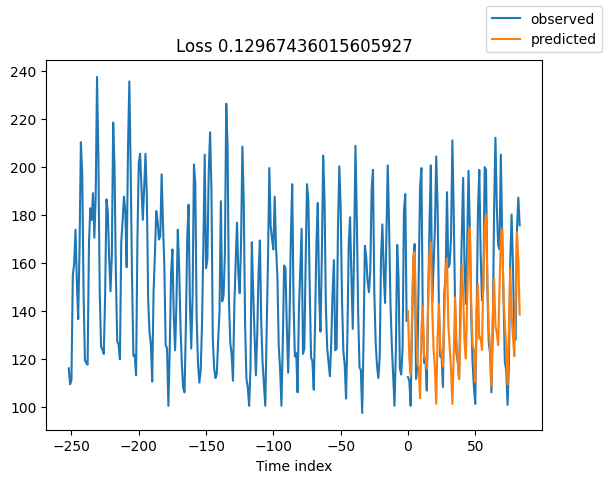

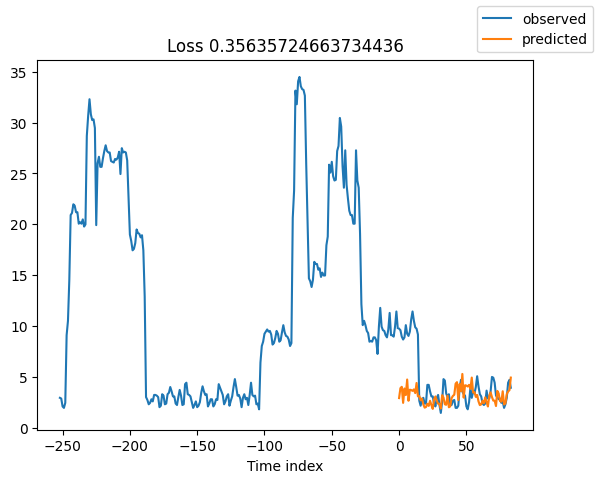

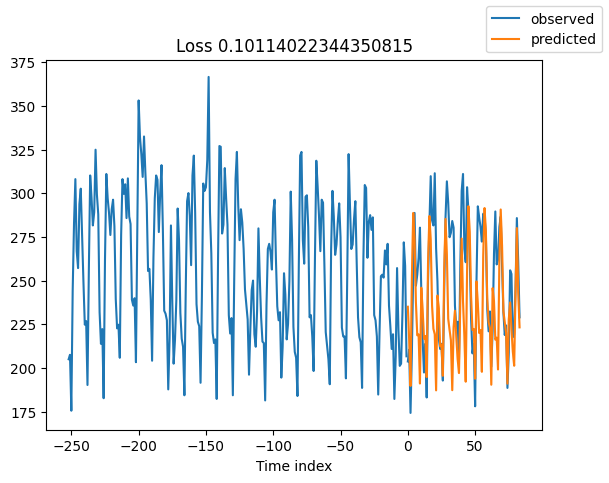

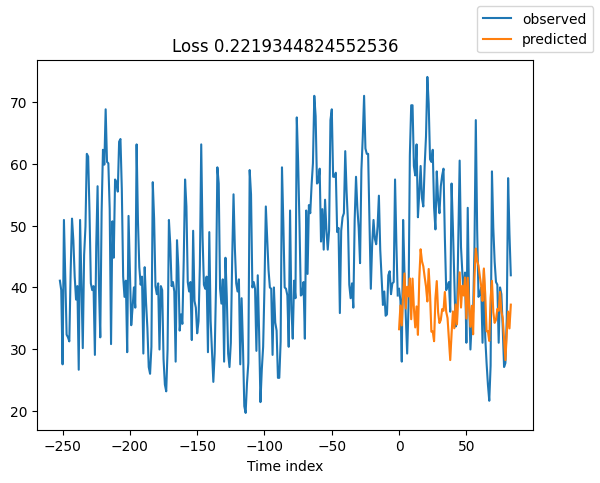

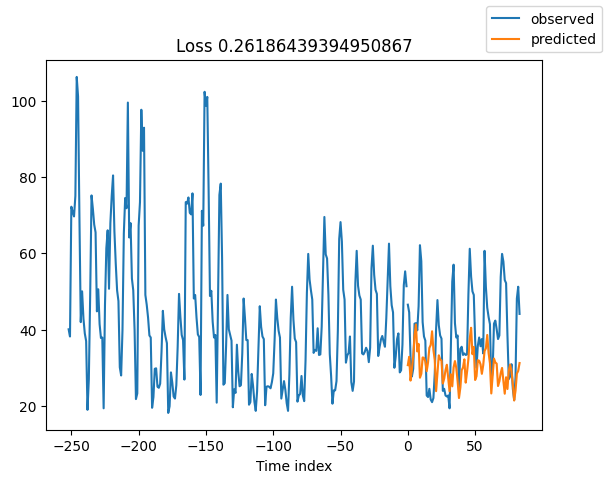

In [27]:
preds = best_model.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(preds.x, preds.output, idx=idx, add_loss_to_title=MAPE(),)

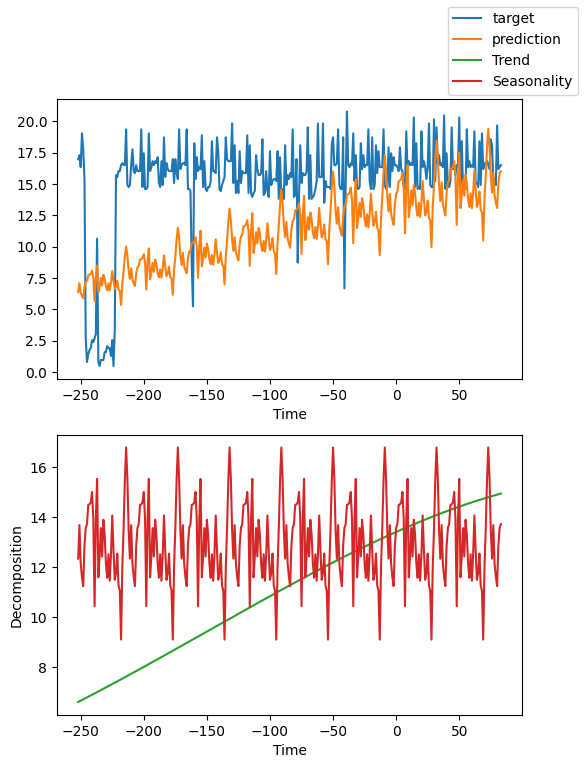

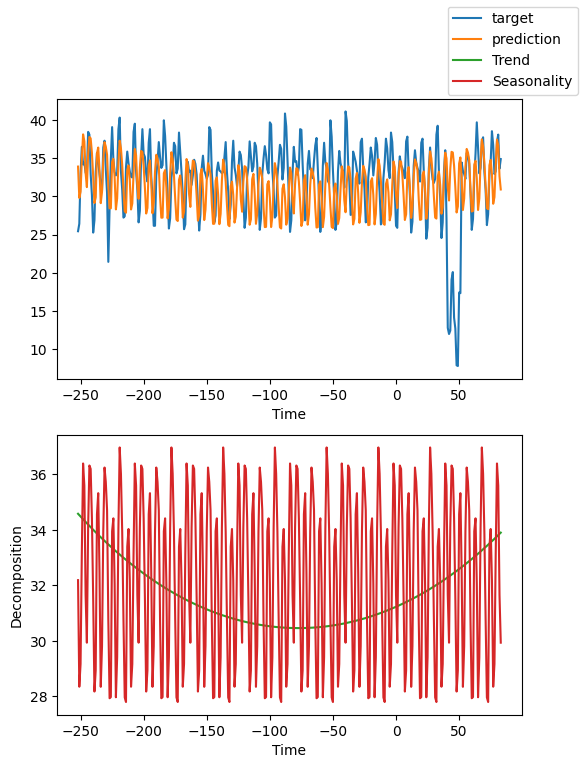

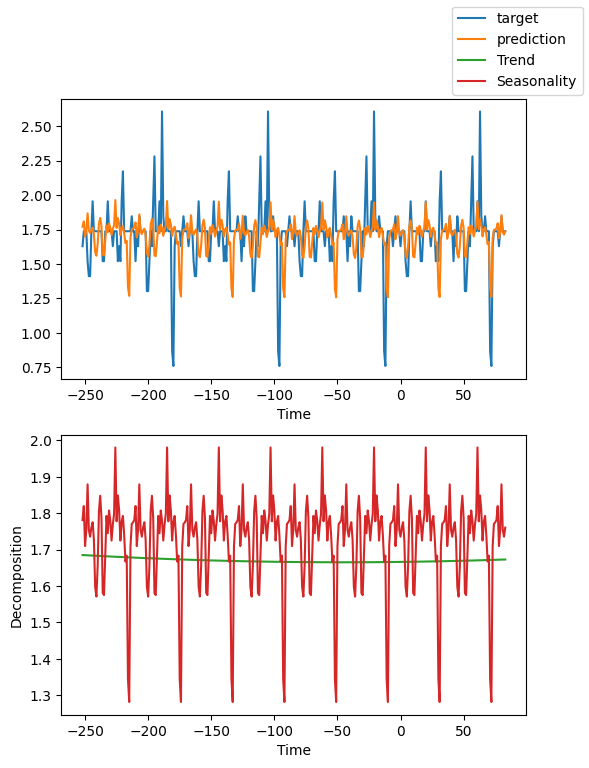

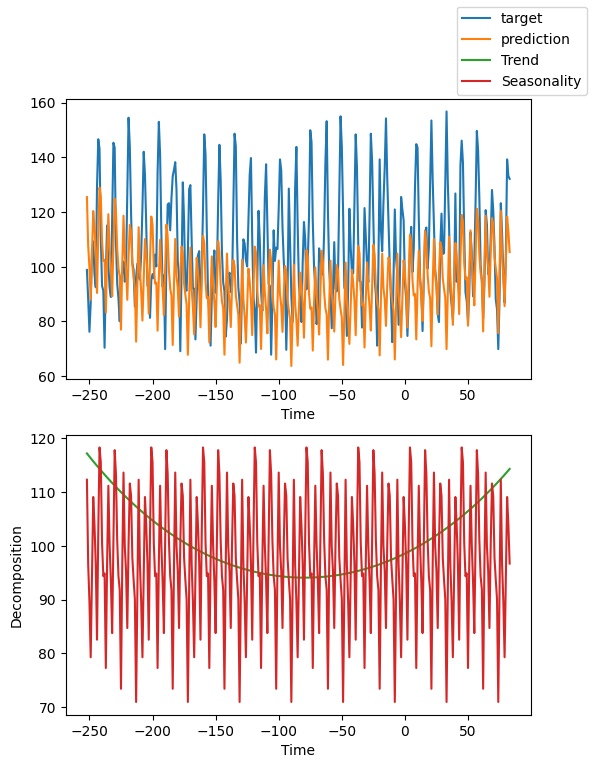

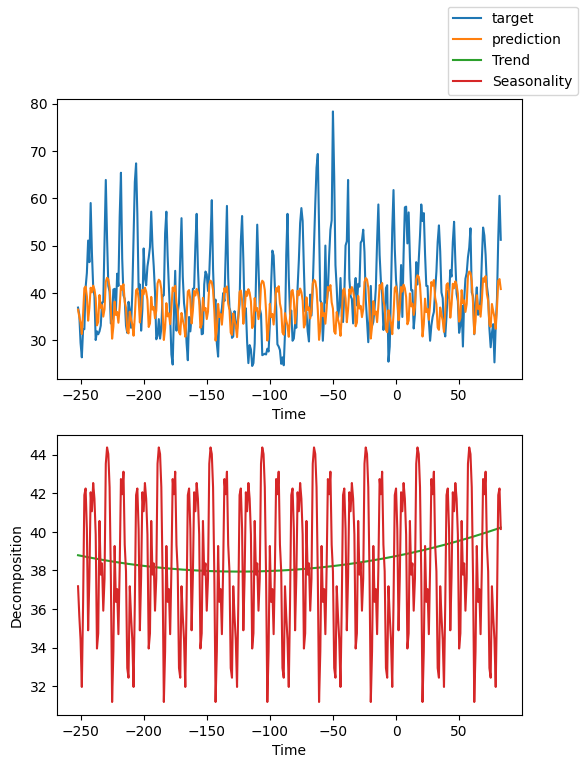

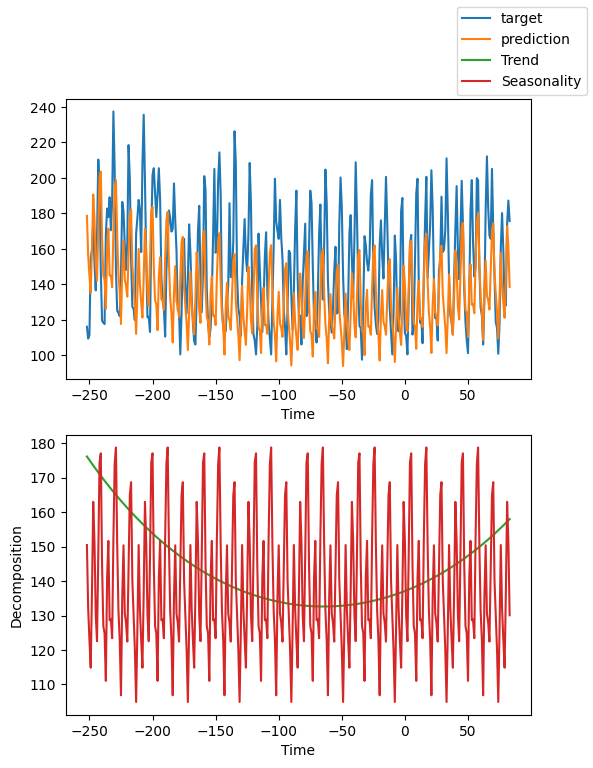

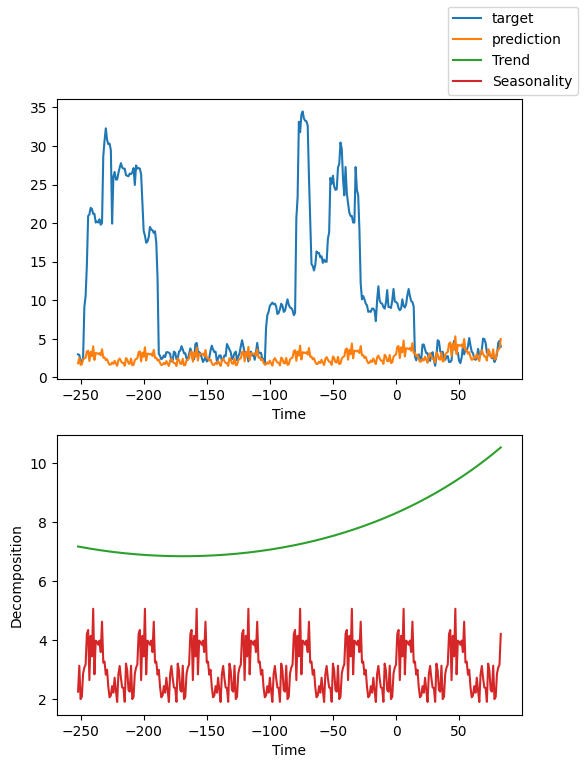

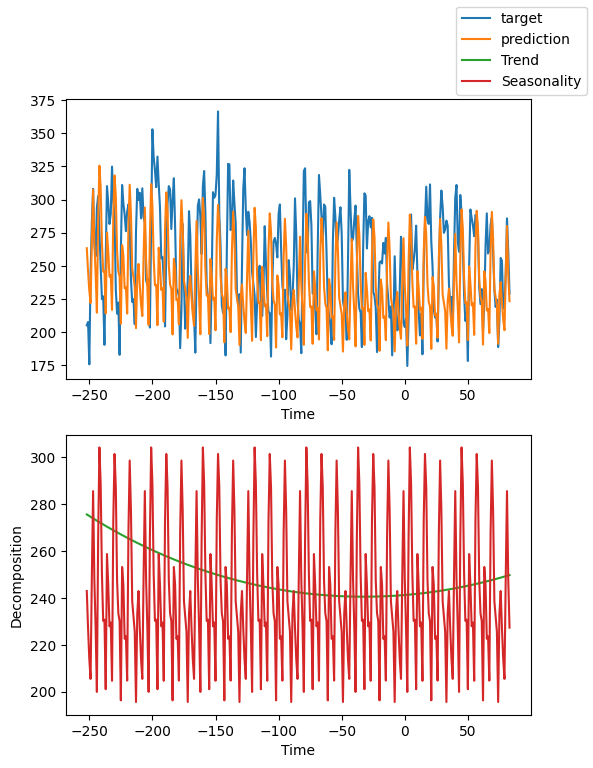

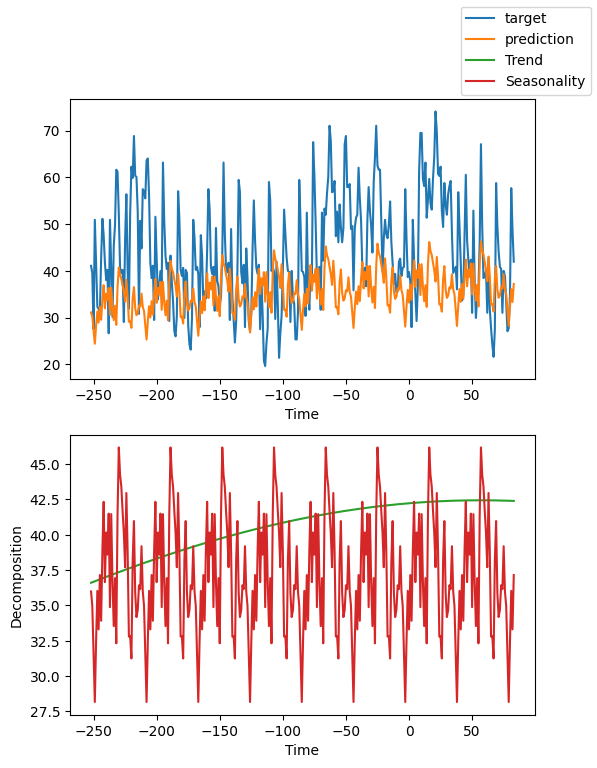

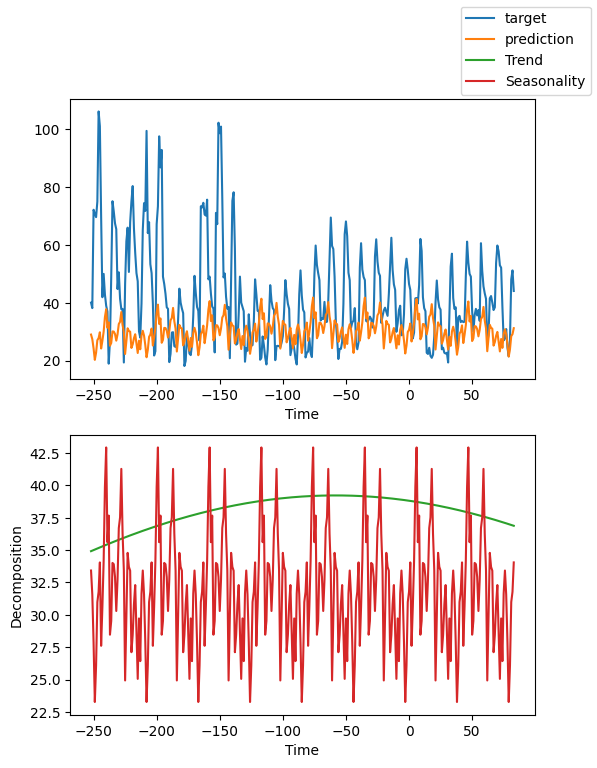

In [25]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(preds.x, preds.output, idx=idx)